In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
sns.set(color_codes=True)


### Task 1

#### Naive Analysis
In this analysis being an EPFL student doesn't really help. We will try to immitate the analysis of a naive researcher for the specific dataset. The dataset represents the NSW training programm results. This research was conducted to show the efficiency of the training programm in terms of income after the end of it. The people are being divided in two categories: The ones that participated in the programme (treat == 1) and the others that did not (treated == 0). These two categories form two groups the:
   
    1. The treated group
    2. The control group
    
Thus the dataset incudes some features useful for the analysis as the gender, the race, the income after the end of the programme referring to these groups.

In order for our analysis to start, we loaded the dataset at first. And we made a copy of that in order to manipulate it as we want.

In [24]:
lalonde_raw = pd.read_csv('./lalonde.csv')
lalonde_data = lalonde_raw.copy()
lalonde_data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


Our naive analysis starts with the seperation of the dataset in two dataframes, each of which includes the seperate groups. On the one hand there are the trained and on the other the people that they didn't attend the programme.

In [25]:
treated = lalonde_data.loc[lalonde_data['treat'] == 1] #People that attained the programme
control = lalonde_data.loc[lalonde_data['treat'] == 0] #People that didn't attain the programme

After that step we thought that the easiest and most naive way to extract some statistical information for our dataset would be to use the built in function of pandas, which calculates some statistical features of the dataframe provided. So we apply this function to the seperate datasets just to see if there are some obvious inferences.

In [26]:
treated.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [27]:
control.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


As our analysis is superficial we will focus our attempts of extracting useful information about the result of the programm only on specific features. This is why we decided that we will stick only with the income level after the completition of the programme. Thus we filtered the two datasets to include just this attribute.

In [28]:
treated.re78.describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [29]:
control.re78.describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

With the statistical information that we have extracted we can now infer some relations and notice differences between the two groups.

First of all we notice, that the dataset is not balanced and this should trigger us some thoughts about the detailed analysis later.. But in general we notice that the number of treated people is almost half of the people that were belonging to the control group. Leaving that behind and not taking into consideration that the statistics might be biased someone can observe the following things:

1. <b>Mean:</b> For the treated group we can notice, that the mean value of the re78 is <b>6349</b> whereas for the control group is a higher <b>6984</b>. This difference of <b>635</b> shows that the people that didn't attend the training programme achieved higher income. Something that is counter-intuitive according the target of the programme.

2. <b>Min:</b> We can also observe that in both categories there were trained people,who continued to stay unemployed and having zero income. And of course people, who hadn't participated in the programme and they didn't have income in any case.

3. <b>Percentiles:</b> From the percentiles we can observe that apart from the first percentile where the income of the treated group is higher in every other percentile the income of the non-treated(control group) is much greater. 

4. <b>Max:</b> The maximum income of the two groups indicates that the maximum income indeed comes from the treated group and the difference is quite big as the trained group has 3 times higher income than the untrained (<b>60307 vs 25564</b>).

Given that the numbers (statistical analysis) don't give us a solid intuition and eventually a result of which group performed better in terms of income after the end of the programme,we decided to visualize also the 2 distributions in order to have a better picture.

In [30]:
def distr_comp(df1,df2,col,title,xl,yl):
    plt.figure(figsize=(15,6))
    ax = sns.distplot(treated[col], hist=True, label='treated');
    ax = sns.distplot(control[col], hist=True, label='control')

    ax.set(title=title,xlabel=xl, ylabel=yl)
    plt.legend()
    plt.show()

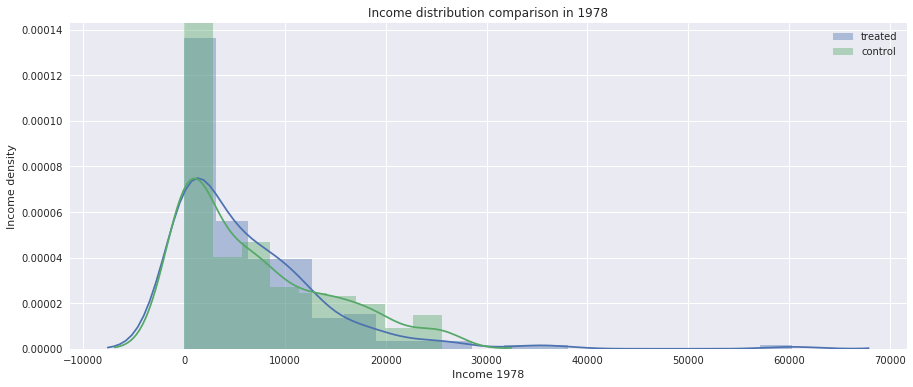

In [31]:
distr_comp(treated,control,'re78','Income distribution comparison in 1978','Income 1978','Income density')

In the plot above we can observe more or less that the two groups share shame distribution over the income. The difference, which we observe though is that in general the untrained people are having much higher income in most cases. They obviously dont have the highest income as there are records of trained people with the maximum income recorded but in the interval between <b>12000 - 27000</b> the control group outperform the treated one. Also the intervals where the number of treated is higher are the ones that correspond to lower income. We have to take into consideration that under the umbrella of naive approach we don't perform a more extensive research on how the distribution behave if we decrease the bin size-(in order to fit the data much more precisely).

<b>Conclusion Naive Analysis</b>

We conclude that in general the control group outperforms the treated one in most of the cases and we get the intuition, that eventually participating in the programme didn't really help the participants in terms of future income increase. The statistics but also the distributions indicate that (without minding standard deviation) in average the control group has higher income. 

The treated group has:
    1. lower mean earnings value
    2. higher first (25%) percentile - low income interval (though)
    3. Some outliers of really high income rates - with maximum income
The control group has:
    1. higher mean earnings value
    2. higher percentile (50%,75%)
    3. higher number of people with income in the interval 12000 - 27000
    4. possible* higher unemployment rate (as higher number of 0 income means unemployment) 

However as we also noticed in the beginning the dataset is not balanced and the control group has much more members than the one of treated. Due to our naive analysis we will leave this detail(important in statistics point of view) aside. 

*We say possible because in our naive analysis we didn't tried greater number of bins in the histogram.

#### A closer look at the Data

In order to take a closer look on the dataset we thought that we should use more features in order to reach a soid conclusion. So the first thing is to see how much correlation exist between the attributes of the dataset. To do that we will plot a pairwise correlation of each feature. We are interested in specific pairs, so we will comment only on the significant ones.

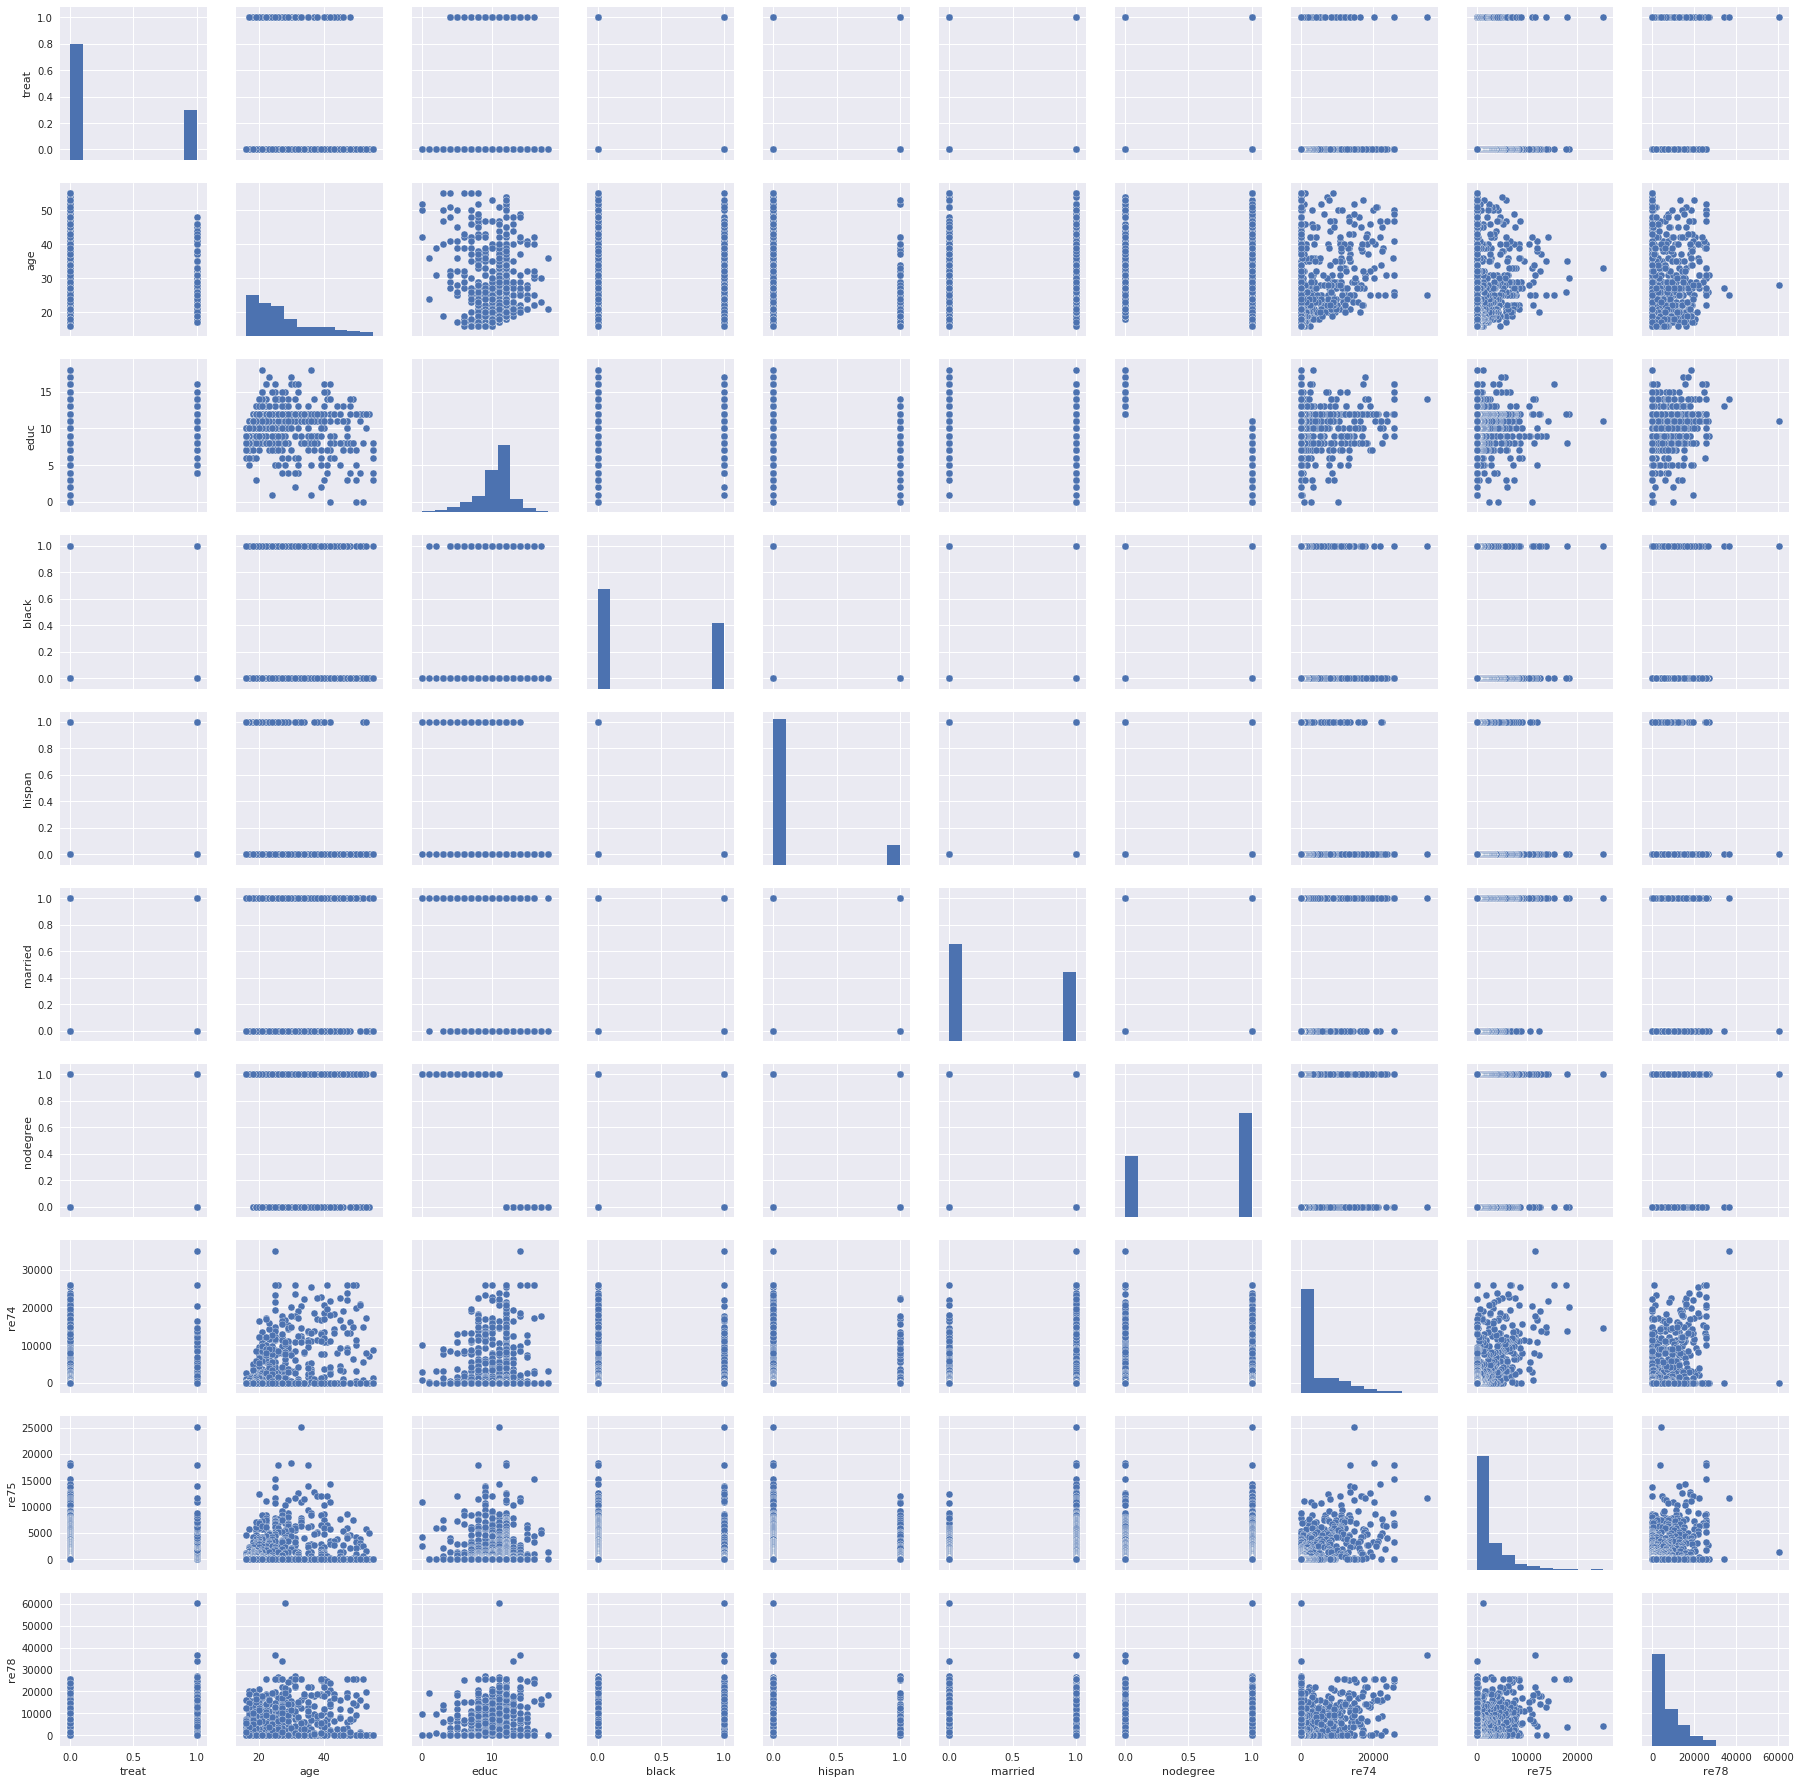

In [32]:
sns.pairplot(lalonde_data)

We have to comment, that we used pairplot for simplicity of code. We would examine only the first column, where we can see the correlation between the two groups and the features. Additionally since some attributes are categorical like married,race...will not examine them now but in the next stages. From the correlation plots we can notice that:

1. The number of records for the treated is higher than the records for the control group
2. The control group includes much larger range of ages whereas the treated one has members with age between 18-50
3. The education level of all the members of the treated group is above 4 years whereas in the control group there are also members that have not education at all.
4. We can also notice some outliers in the data on the plots of incomes during the recorded years.

Now that we have observed some special aspects of our dataset we will analyze them more in depth. We will do that using some basic statistical principles like visualization techniques and other more robust statistical metrics.

### Age 
We will first investigate the age distribution of the two groups. We notice that there is much difference between the tow groups on this attribute. As we noted previously the members of the treated tend to be younger than the ones in the control group. We 've reached this conslusion from the boxplot below. However the median of the two groups is not so different.

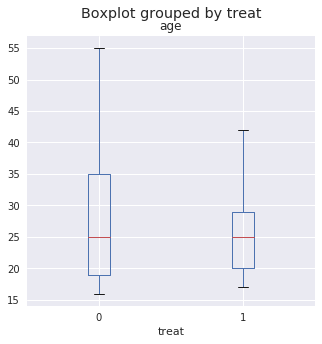

In [33]:
lalonde_data.boxplot(by='treat', column='age', figsize = [5, 5], grid=True)
plt.show()

Its easy to observe from the plot below that the age distribution is quite different between the two groups. In the treated group there are much more members in the ages between 18-28 and in the control group there are much more members in the interval 34-55.

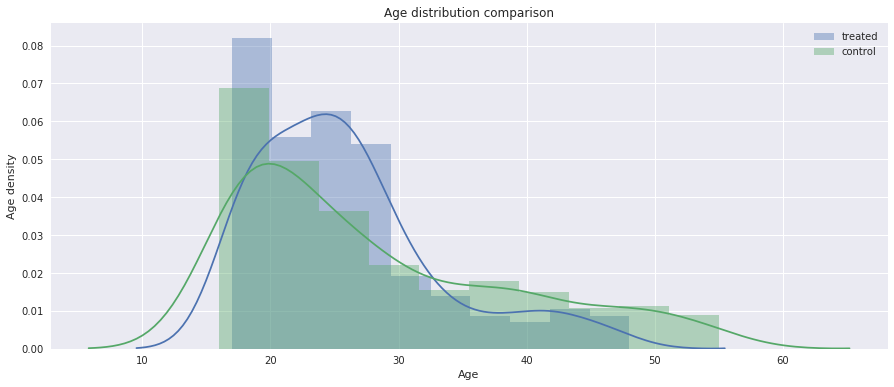

In [34]:
distr_comp(treated,control,'age','Age distribution comparison','Age','Age density')

Below we sketch a Q-Q plot to see if the distributions are similar. If the two distributions being compared are similar, the points in the Q–Q plot will approximately lie on the line y = x. If the distributions are linearly related, the points in the Q–Q plot will approximately lie on a line, but not necessarily on the line y = x. If the points follow a strongly nonlinear pattern then the distributions are not similar.

In [35]:
def qq(df,col):
    fig_qq, ax_qq = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

    stats.probplot(df[df.treat == 0][col], dist="norm", plot=ax_qq[0])
    stats.probplot(df[df.treat == 1][col], dist="norm", plot=ax_qq[1])
    ax_qq[0].set_title('Control Group')
    ax_qq[1].set_title('Treated Group')
    plt.show()

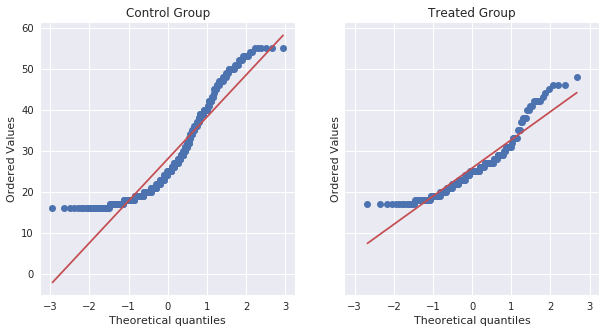

In [36]:
qq(lalonde_data,'age')

### Education
We will implement the above and same logic for the attribute of education.


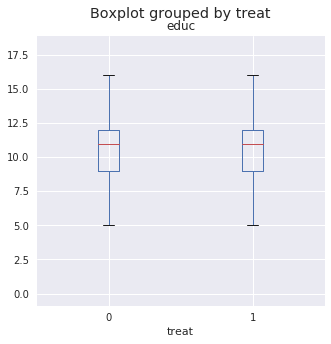

In [37]:
lalonde_data.boxplot(by='treat', column='educ', figsize = [5, 5], grid=True)
plt.show()

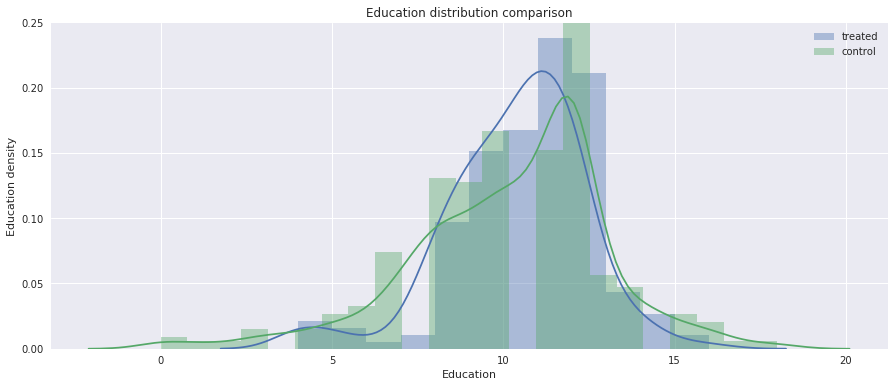

In [38]:
distr_comp(treated,control,'educ','Education distribution comparison','Education','Education density')

We can observe here easily that the treated group has no members that have never been educated whereas the control group has. Every other interval is difficult to infer as there are outliers.

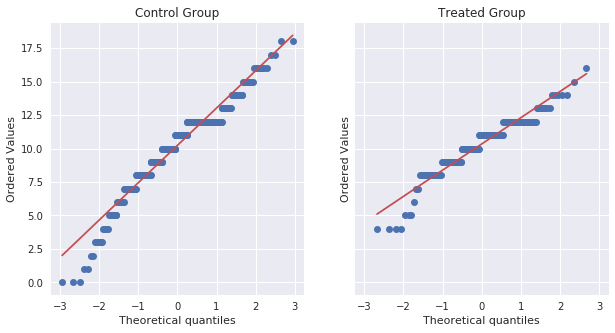

In [39]:
qq(lalonde_data,'educ')

### Income of previous year 1974


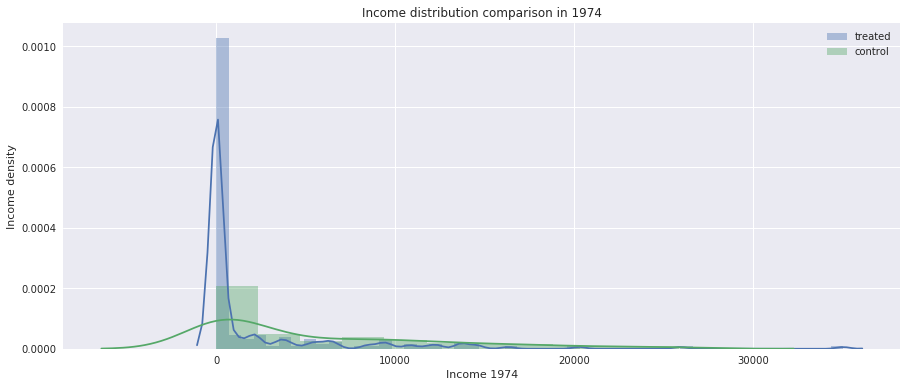

In [40]:
distr_comp(treated,control,'re74','Income distribution comparison in 1974','Income 1974','Income density')

As we can observe from this attribute the number of treated members that were unemployed before the training programme is quite high. So this might gives us an intuition of how much the programm helped people to find a job independently of the income that they got eventually. This is also obvious from the boxplot bbelow where we can notice that although there are employed members in the control group in the treated one there is quite high unemployment.

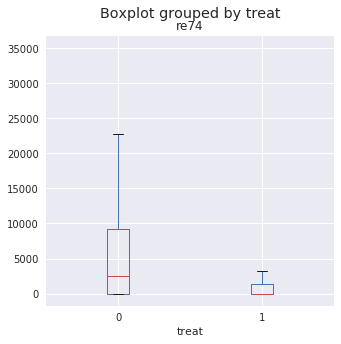

In [41]:
lalonde_data.boxplot(by='treat', column='re74', figsize = [5, 5], grid=True)
plt.show()

### Categorical Data

In [42]:
def cat_plot(df,col):
    group = df.groupby(['treat', col])[col].count()
    group = group.unstack()
    group = group.div(group.sum(axis=1), axis=0)
    pl = group.plot(kind='bar', figsize=[7,5], rot=0)
    pl.set_title(col)
    pl.set_ylabel('participants')
    pl.set_xlabel('group')
    plt.show()

### Marriage


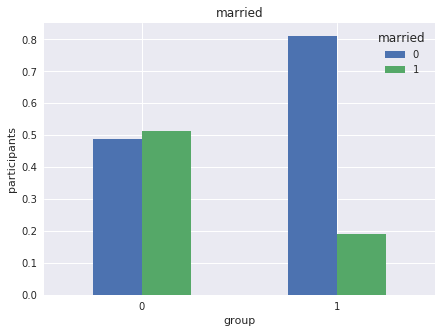

In [43]:
cat_plot(lalonde_data,'married')

As far as we can see the percentage of the unmarried people between the treated group is much higher than the married ones whereas in the control group the two categories are balanced. This might be an indication of what type of people they tried to include in their programme. 

### Degree Holder

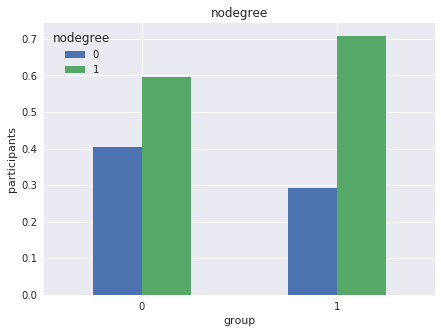

In [44]:
cat_plot(lalonde_data,'nodegree')

We observe that in both groups the number of people that do not have a degree is higher than the ones that have one.However the difference in the treated group is much higher. 

### Race
In order to infer the white race also we will create a logical operation between the other two races and the difference will be the white race.

In [45]:
lalonde_data['white'] = (~(lalonde_data['black'].astype(bool) | lalonde_data['hispan'].astype(bool))).astype(bool)

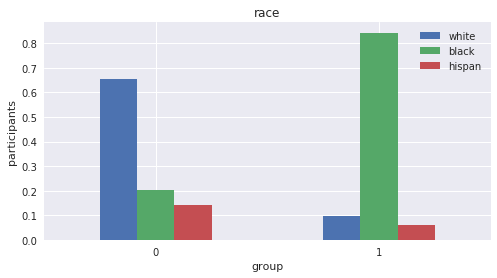

In [46]:
lalonde_data_group = lalonde_data.groupby(lalonde_data.treat)['white', 'black', 'hispan'].sum()
lalonde_data_group = lalonde_data_group.div(lalonde_data_group.sum(axis=1), axis=0)
pl = lalonde_data_group.plot(kind='bar', figsize=[8,4], rot=0)
pl.set_title('race')
pl.set_ylabel('participants')
pl.set_xlabel('group')
plt.show()

So about the racial features of the two groups is very obvious that the white outnumber the other races in the control group and on the other hand in the treated group the proportion of black is almost the only one. The black race have a percentage above 80% of the whole people in the dataset.

### Abstract

In this task we were introduced with the problem of text classification. Given 18'846 text samples from different sources, we were asked to build a model which would correctly predict in which of the 20 possible classes the given input belongs to. For this purpose we converted the text samples into numerical vectors based on TF-IDF and obtained a transformed dataset of size $18'846\times173'762$.

The algorithm of choice for this task is random forests, which required grid searching the necessary parameters prior to training. The training, parameter tuning and evaluation steps were done using train, validation and test sets, respectively, following the holdout strategy with a 80-10-10 split.

The overall accuracy of the model on the test set is 84.62%, based on 64'476 of the most significant features or 37.1% of the total size of the feature space. The top 20 words that contribute the most to the classification are: <i>sale</i>, <i>dod</i>, <i>windows</i>, <i>car</i>, <i>re</i>, <i>clipper</i>, <i>of</i>, <i>bike</i>, <i>the</i>, <i>god</i>, <i>hockey</i>, <i>to</i>, <i>israel</i>, <i>is</i>, <i>encryption</i>, <i>space</i>, <i>lines</i>, <i>that</i>, <i>in</i> and <i>graphics</i>.

### Loading and analysing the data

Naturally, the first step is to load the dataset using `sklearn`. Instead of always fetching the data from the different sources, the method is caching it on a provided path. In our case, we pass the `data` folder as the place where the caching can be done.

In [62]:
news_raw = fetch_20newsgroups(data_home='./data', subset='all')

The data needed for the solution of the problem lies in the `data` and `target` attributes. Another useful variable is `target_names` and can be used to map the target attribute, which is the index of the category represented as an integer, to a more meaningful label.

First of all, let us examine the dimensionality of the data, to get a sense of the load we will be dealing with.

In [292]:
print(len(news_raw.data))
print(len(news_raw.target_names))

18846
20


There is a total of 18'846 texts that are classified into 20 possible categories or topics.

It would be much more convenient to work with the true class labels in their textual form instead of the indices that point to the array positions where they can be fetched.

In [293]:
# Make the class labels textual
class_lbl = []
for lbl_num in news_raw.target:
    # Map the label index to the label textual value
    class_lbl.append(news_raw.target_names[lbl_num])
class_lbl = np.array(class_lbl)

Let us visualise the distribution of the class labels for the dataset.

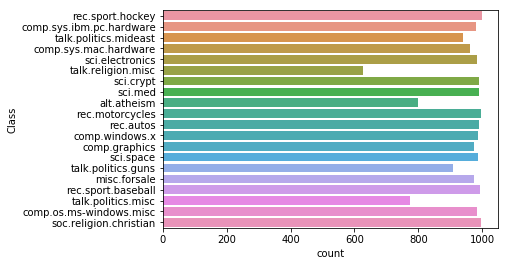

In [308]:
class_df = pd.DataFrame(class_lbl, columns=['Class'])
sns.countplot(y="Class", data=class_df)
plt.show()

Based on the above plot which represents the data samples count for each class label, we don't deem necessary to introduce weights to balance the classes or introduce any additional techniques to cope with that issue, since all the classes are pretty balanced (with a few exceptions, but they are not extreme).

### Creating the feature vectors

The next step before training a classifier is to create a numerical vector representation for each text sample. This is easily achieved using tf-idf (term frequency-inverse document frequency), which counts the number of times a word appears in the text, but normalises (scales) that count with the measure of how many dataset texts it appears in. This will help uncover the prominence of a word for a particular text sample.

A word is only useful for the purpose of classification if it is very frequent in a particular text sample from a certain category, but doesn't appear often in other texts labelled differently. And that is exactly what tf-idf measures.

In [309]:
vectorizer = TfidfVectorizer()
doc_term_matrix = vectorizer.fit_transform(news_raw.data)
doc_term_matrix.shape

(18846, 173762)

The resulting dataset now has 18846 text samples, each being a 173762-dimensional numeric vector. Each dimension corresponds to a particular word from the corpus formed by the entire news dataset.

In [327]:
print(doc_term_matrix.nnz)  # number of non-zero entries in the matrix
print(doc_term_matrix.nnz / (doc_term_matrix.shape[0] * doc_term_matrix.shape[1]) * 100)  # percentage of non-zero entries

2952534
0.09016145549471162


Naturally, the result is a very sparse matrix (with many zero values). Only 2'952'534 out of 3'274'718'652 entries in the sparse matrix are non-zero, which is a percentage of approximately 0.09.

### Setting the evaluation prerequisites

Having finished with the pre-processing and the exploratory analysis of the data, the logical next step to discuss is a way to train and evaluate the model. For tackling the given problem, we propose to use the holdout strategy according to which 80% of the dataset will be used to train the model, 10% will go into the validation set that will be helpful when tweaking and hypertuning the parameters of the model, and the final 10% are left for the final evaluation of the model.

In order to get the highest amount of flexibility in partitioning the dataset, we implement our own function for the holdout method.

In [131]:
def split_dataset(dataset, labels, train_percent=0.8, validation_percent=0.1, test_percent=0.1):
    num_samples, num_features = dataset.shape
    
    # A total round error of 2 is possible in favour of the test set, 
    # i.e. the test set might have 2 more samples than the requested percentage
    train_number = int(num_samples * train_percent)
    validation_number = int(num_samples * validation_percent)
    test_number = int(num_samples * test_percent)
    
    # Make a random permutation of the indices which would go in each set
    perm = np.random.permutation(num_samples)

    # Split the indices for the rows that would be included in each set
    train_set_idx = perm[:train_number]
    validation_set_idx = perm[train_number:(train_number + validation_number)]
    test_set_idx = perm[(train_number + validation_number):]

    # Create the actual sets
    train_set = dataset[train_set_idx, :]
    validation_set = dataset[validation_set_idx, :]
    test_set = dataset[test_set_idx, :]
    
    # Split the labels accordingly
    train_set_lbls = labels[train_set_idx]
    validation_set_lbls = labels[validation_set_idx]
    test_set_lbls = labels[test_set_idx]
    
    return train_set, train_set_lbls, validation_set, validation_set_lbls, test_set, test_set_lbls
    
train, train_lbl, validation, validation_lbl, test, test_lbl = split_dataset(doc_term_matrix, class_lbl)

In [132]:
print(train.shape, train_lbl.shape)
print(validation.shape, validation_lbl.shape)
print(test.shape, test_lbl.shape)

(15076, 173762) (15076,)
(1884, 173762) (1884,)
(1886, 173762) (1886,)


The above output shows the dimensions of each set, i.e. the number of samples that fall into each one of them.

### Best parameters search

Finally, we reached the point where everything is ready to start with the classificator training process. Since random forests depend on a few parameters, namely the number of trees that will be trained and the maximal depth of each tree, we need to perform a grid search over a range of different values to be able to make an informed decision which ones to set in order to get the best classifier.

The number of trees lower bound is set to 10, which is the default value that the `RandomForestClassifier` method will take, and the upper bound is 160 (inclusive). This assures a large enough range that will be informative enough as to whether we need to extend the search to 170 and over or this will suffice and we will get the optimal parameter within this given range.

Training a random forest once, without setting the `max_depth` parameter resulted in trees whose depth ranged from 200-300, therefore the grid search values was chosen to range from 150 to 300 (inclusive). 

Of course, the range values are based on intuition, hunches and reasonable guesses. The analysis that follows is crucial to provide intel which parameter values are the ones worth to be taken into consideration.

The evaluation for the classifier performance is based on the accuracy measure obtained on the validation dataset.

In [ ]:
# Grid search for the best parameters
evaluation = []
for num_trees in range(10, 170, 10):
    print("Random forest with:", num_trees, "trees")
    for depth in range(150, 310, 10):
        if depth % 50 == 0:
            print("----- depth:", depth)
            
        # n_jobs = -1 sets the number of parallel threads to the number of cores available
        clf = RandomForestClassifier(n_estimators=num_trees, n_jobs=-1, max_depth=depth)
        # train the classifier
        clf.fit(train, train_lbl)
        # create predictions on the validation test
        validation_predicted_lbl = clf.predict(validation)
        # compute accuracy value
        accuracy = metrics.accuracy_score(validation_lbl, validation_predicted_lbl)
        
        evaluation.append([num_trees, depth, accuracy])
        
grid_search_results = pd.DataFrame(np.array(evaluation), columns=['Number of trees', 'Max depth', 'Accuracy'])

At this point, it would be a good idea to plot the obtained results from the performed grid search, just to get an intuition of how the two classifier parameters: number of trees and maximum depth, affect the overall accuracy of the trained model.

Since there are only 3 variables in question, all of which numerical, they can be easily represented in 3D space. A surface plot showing accuracy as a bivariate function of the number of trees and maximum depth is the most suitable.

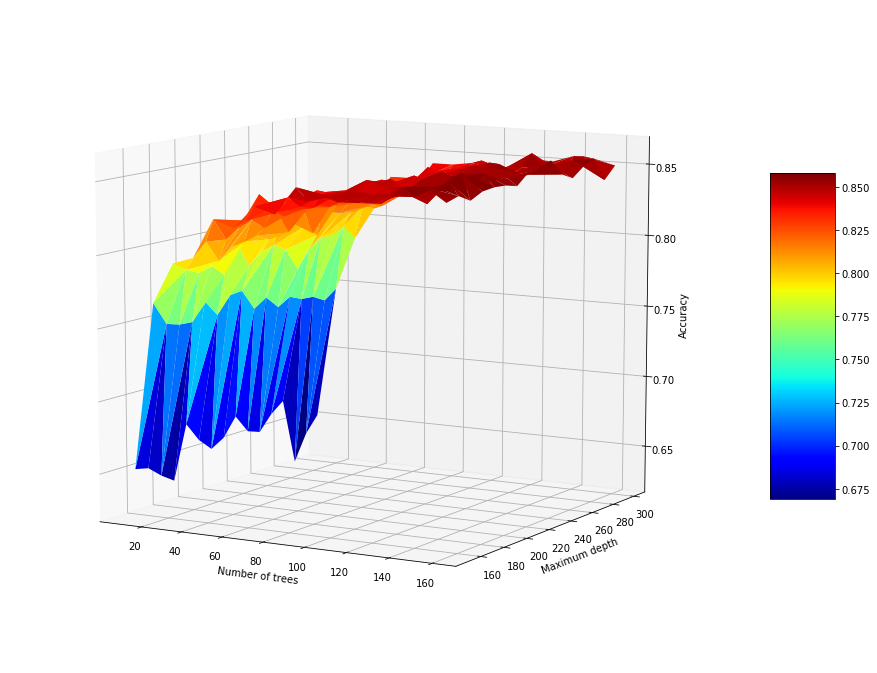

In [281]:
# Create the plot
fig = plt.figure(figsize=(16, 12))
ax = fig.gca(projection='3d')
 
# Maps values to colours
surf = ax.plot_trisurf(grid_search_results['Number of trees'], grid_search_results['Max depth'], grid_search_results['Accuracy'], cmap=plt.cm.jet, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)

# Rotate the plot for better visualisation
ax.view_init(10, 300)

# Label the axes
ax.set_xlabel('Number of trees')
ax.set_ylabel('Maximum depth')
ax.set_zlabel('Accuracy')
plt.show()

The above figure is a surface plot typically used to visualise multivariate data. In this context, it shows the accuracy values of the random forest algorithm for different model parameters obtained by grid search. The tuned parameters are: number of trees and maximum tree depth. We experimented with a range of the number of trees in the random forest from 10 to 160 (inclusive), with a step size of 10. The range for the trees' maximum depth is from 150-300 (inclusive), again using a step size of 10. The plot shows a very steep rise in the accuracy of the classifier once the number of trees in the forest starts increasing from 10, but then there is an evident plateau once the value surpasses 90.

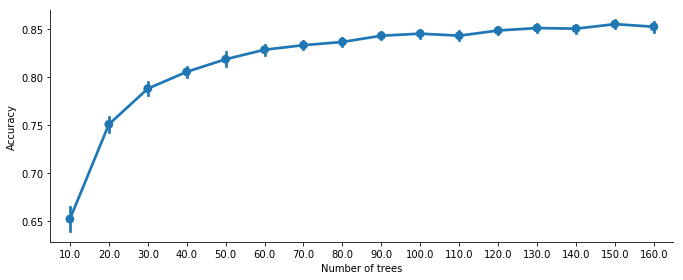

In [331]:
sns.factorplot(x="Number of trees", y="Accuracy", data=grid_search_results, ci='sd', size=4, aspect=2.4)
plt.show()

The line chart plot automatically aggregates the data by grouping the values according to the number of trees and computing the average accuracy over the range of tree maximum depth values. The plot also shows the standard deviation for each point as a line which eventually becomes barely visible as the values get much closer to the mean.

Here it is even clearer that there isn't a big improvement, i.e. accuracy gain, as the number of trees in the random forest increases above 90. Yes, the absolute values for the accuracy may vary depending on the choice of the validation set, but we expect that the trend for accuracy gain will remain unchanged. Therefore, we're not going to explore further values for the number of trees and we'll just take the one that, on average, provides maximum accuracy based the data we already have, which is 150.

The following plot shows the accuracy in terms of the maximum depth for the case when the random forest consists of 150 trees.

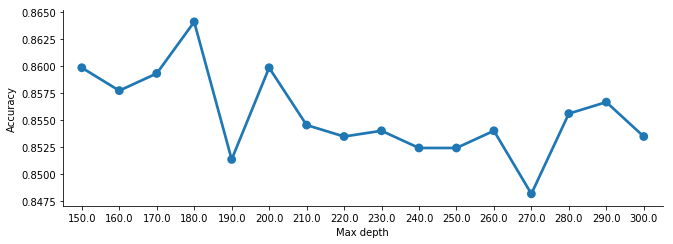

In [277]:
sns.factorplot(x="Max depth", y="Accuracy", data=grid_search_results[grid_search_results['Number of trees'] == 150], size=3.5, aspect=2.7)
plt.show()

According to the plot, it is justified to say that a reasonable value for the `max_depth` parameter is 180.

Therefore, following the analysis made in the previous steps of the task, which included a grid search over a predefined range of parameter values and analysis of the behaviour of the model in terms of accuracy over a validation set, the conclusion is that it should be proceeded with a random forest of 150 trees, each one with a maximum depth of 180. These are the parameters that will be used for the final solution.

### Building a classifier with the best parameters

In [282]:
# n_jobs = -1 sets the number of parallel threads to the number of cores available
clf = RandomForestClassifier(n_estimators=150, max_depth=180, n_jobs=-1)

In [283]:
clf.fit(train, train_lbl)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=180, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [284]:
test_predicted_lbl = clf.predict(test)

Once the class labels for the test set are predicted, the actual and the predicted labels can be best visualised using a confusion matrix. That will provide insight of how good the classifier is. Of course, having 20 different class labels, it becomes fairly difficult to interpret the numbers without spending some time and attention. Therefore, the confusion matrix is also given in a graphical variant that is more human-perceptible and significantly easier to comprehend.

In [333]:
confusion_matrix = pd.crosstab(test_lbl, test_predicted_lbl, rownames=['Actual Class'], colnames=['Predicted Class'])
confusion_matrix

Predicted Class,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
Actual Class,,,,,,,,,,,,,,,,,,,,
alt.atheism,62,0,0,0,0,1,1,0,0,0,0,0,0,0,3,3,0,1,0,2
comp.graphics,0,70,4,2,7,6,3,0,0,0,0,0,1,0,3,0,0,0,0,0
comp.os.ms-windows.misc,0,6,72,4,1,2,2,0,0,0,0,0,2,0,0,0,0,0,0,0
comp.sys.ibm.pc.hardware,0,6,13,76,6,2,0,0,1,0,0,0,1,0,2,0,0,0,0,0
comp.sys.mac.hardware,0,1,2,4,80,0,5,1,0,0,0,0,1,0,0,0,0,0,0,0
comp.windows.x,0,10,5,1,1,75,0,0,0,0,0,0,0,1,0,0,0,0,0,0
misc.forsale,0,1,0,3,2,1,94,1,1,1,0,0,2,0,0,2,0,0,0,0
rec.autos,0,3,0,0,1,0,3,89,3,1,0,0,0,0,0,0,2,0,0,0
rec.motorcycles,0,0,0,0,0,0,3,2,91,0,0,0,0,0,0,0,0,0,0,0


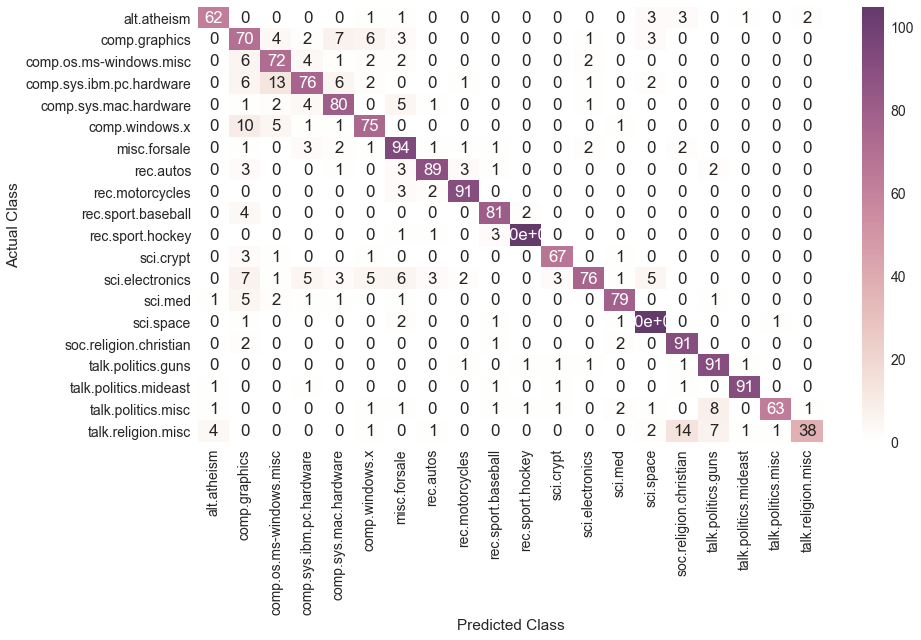

In [357]:
colour_palette = sns.cubehelix_palette(light=1, dark=0.3, as_cmap=True)
plt.figure(figsize = (14, 8))
sns.heatmap(confusion_matrix, cmap=colour_palette, annot=True)
plt.show()

An interesting observation to make based on the confusion matrix is that most of the misclassifications occur for classes which are very similar, sometimes even overlapping one might say. Let's take `talk.religion.misc` and `soc.religion.christian` as an example. It's not just that the topics are not disjoint, but moreover the former might be considered a superset of the latter. Same with `talk.politics.guns` and `talk.politics.misc`.

Other more significant misclassifications occur due to the fact that the texts only differ in the subgroups, so they contain similar language, terms and jargon, which makes it very difficult to tell them apart. Handling these ambiguous cases greatly depends on the use-case. We cannot say this is bad classification a-priori. For example, if the use-case is a recommendation system which suggests news or threads to a user, then it might not be completely undesirable to show texts from a very similar category, even though theoretically it doesn't belong in the same class.

### Discussion of the different evaluation metrics

To better evaluate the classifier, we used the well-known F-measure metric as addition to the classifier's accuracy. The F-measure combines the precision and recall scores using the harmonic mean. The formulas for each evaluation measure is given below. 

\begin{equation}
    \pi=\frac{TP}{TP+FP} \qquad
    \rho=\frac{TP}{TP+FN} \qquad
    F=\frac{2\pi\rho}{\pi+\rho}
\end{equation}

In the above equations `TP` = <b>T</b>rue <b>P</b>ositive, `TN` = <b>T</b>rue <b>N</b>egative, `FP` = <b>F</b>alse <b>P</b>ositive and `FN` = <b>F</b>alse <b>N</b>egative. As these metrics were discussed in class, there shouldn't be any necessity to go over their meaning once again here.

What might be important to mention is the not so straight-forward way of computing the precision and recall measure values in the case of multiclass classification. There exist multiple ways of doing so.

1. <i>micro</i>: `F-measure` is computed globally over all category decisions by counting the total true positives, false negatives and false positives. $ \rho $ and $ \pi $ are obtained by summing over all individual decisions. Micro-averaged F-measure gives equal weight to each document and is therefore considered as an average over all the document/category pairs.
2. <i>macro</i>: F-measure is computed locally over each category first and then the unweighted mean over all categories is taken. $ \rho $ and $ \pi $ are computed for each category. This does not take label imbalance into account, but this is not so important in this particular case as the classes are well balanced in the first place.

We provide both measures for the test dataset in order to be more informative.

In [358]:
print('===== accuracy =====')
print(metrics.accuracy_score(test_lbl, test_predicted_lbl))

===== accuracy =====
0.846235418876


In [359]:
print('===== precision =====')
print('- micro:', metrics.precision_score(test_lbl, test_predicted_lbl, average='micro'))
print('- macro:', metrics.precision_score(test_lbl, test_predicted_lbl, average='macro'))

===== precision =====
- micro: 0.846235418876
- macro: 0.856756027419


In [360]:
print('===== recall =====')
print('- micro:', metrics.recall_score(test_lbl, test_predicted_lbl, average='micro'))
print('- macro:', metrics.recall_score(test_lbl, test_predicted_lbl, average='macro'))

===== recall =====
- micro: 0.846235418876
- macro: 0.84378105356


In [361]:
print('===== F-measure =====')
print('- micro:', metrics.f1_score(test_lbl, test_predicted_lbl, average='micro'))
print('- macro:', metrics.f1_score(test_lbl, test_predicted_lbl, average='macro'))

===== F-measure =====
- micro: 0.846235418876
- macro: 0.844881977196


### Discovering the most significant words

One perk of using random forests is that it enables us to see which were the most valuable features the algorithm bases its decisions on. The classifier itself gives access to a list of feature importance values that can be merged with the tf-idf vectorizer feature names, which provide a mapping from coordinate position to the actual word.

The 50 most important words on which the text classification is done are shown as a dataframe in the output below.

In [376]:
feature_importance = pd.DataFrame(clf.feature_importances_, columns=['Significance'])  # Create a dataframe
feature_importance['Word'] = vectorizer.get_feature_names()  # Map the word to its classifier importance value
feature_importance.sort_values('Significance', ascending=False).head(50)  # Top 50 most significant words

,Significance,Word
139570,0.004281,sale
65684,0.003641,dod
165812,0.003326,windows
52100,0.003169,car
133530,0.003024,re
55485,0.003019,clipper
119845,0.002823,of
46061,0.002821,bike
152603,0.002652,the
80391,0.002554,god


It would be interesting to see how many features were used at all in the decision making process. The following lines show that 109'286 out of the 173'762 have zero significance, which means the classification is made based on 37.1% of the features.

In [381]:
(1 - feature_importance[feature_importance['Significance'] == 0].shape[0] / feature_importance.shape[0]) * 100

37.10592649716279

In [384]:
feature_importance_nz = feature_importance[feature_importance['Significance'] != 0]
feature_importance_nz.shape

(64476, 2)

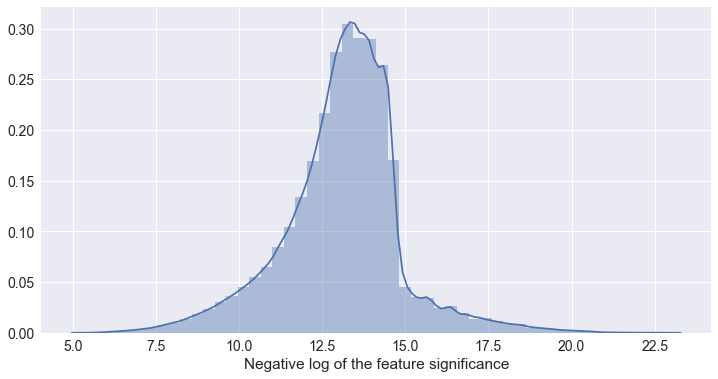

In [395]:
plt.figure(figsize = (12, 6))
sns.distplot(-np.log(feature_importance_nz['Significance']), axlabel="Negative log of the feature significance")
plt.show()

Since the distribution of the most important words is highly skewed, as the majority of them have a very small significance value, it makes more sense to represent them on a negative log-scale rather than one very tall column. Also, the significance values which were initially zero are removed, because they don't really contribute to the process.

It's interesting to notice how among the 50 most significant words there are many stop-words that the algorithm found useful in determining the text class and yet the classification it makes is fairly good. The only seen issues happen when the classes are very similar to eachother, overlap or belong to the same supergroup. As discussed in the previous sections, this might not always be considered a problem because it is use-case dependent.